In [1]:
import scipy.cluster.vq as scv
from PIL import Image
from numpy import array
import numpy as np
from scipy import misc

import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import itertools
import shapely
from shapely.geometry import Point, Polygon, LineString

import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

In [2]:
from palettable.colorbrewer.sequential import Reds_9 

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
df = gpd.read_file('../03_data/keep_data/keep_04_25/new_keep_gdf_all.shp')

<AxesSubplot:>

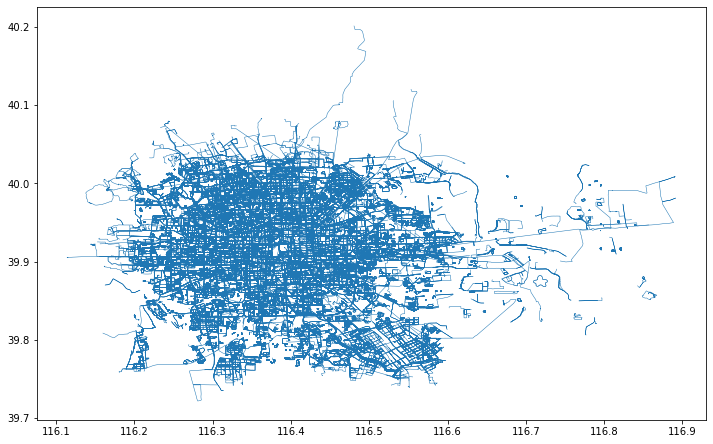

In [5]:
df.plot(figsize = (12,8),linewidth = 0.5)

In [6]:
for i in df.index:
    start_point = df.loc[i].geometry.coords[0]
    df.loc[i, 'start_latitude'] = start_point[1]
    df.loc[i, 'start_longitude'] = start_point[0]
    
    end_point = df.loc[i].geometry.coords[-1]
    df.loc[i, 'end_latitude'] = end_point[1]
    df.loc[i, 'end_longitude'] = end_point[0]

In [7]:
# crs change
df.crs = 'epsg:4326'
df_copy = df.to_crs('epsg:4509')
df_copy.length.head()

0    5047.184529
1    5097.880269
2    5993.164444
3    4858.950754
4    6915.404982
dtype: float64

In [8]:
df['start_date'] = df['start_time'].str.split('_').str[0]
df['start_time_time'] = df['start_time'].str[3:].str.replace('_',":")

df['end_date'] = df['end_time'].str.split('_').str[0]
df['end_time_time'] = df['end_time'].str[3:].str.replace('_',":")

df['start_date'] = '2022/03/'+df['start_date']
df['end_date'] = '2022/03/'+df['end_date']

df['start_datetime'] = pd.to_datetime(df['start_date'] + ' ' + df['start_time_time'])
df['end_datetime'] = pd.to_datetime(df['end_date'] + ' ' + df['end_time_time'])

df['duration'] = df['end_datetime']-df['start_datetime']


df = df[['start_datetime', 'end_datetime', 'start', 'end', 'geometry', 'duration',
         'start_latitude','start_longitude','end_latitude','end_longitude']]


df['start_datetime'] = df['start_datetime'].astype(str)
df['end_datetime'] = df['end_datetime'].astype(str)

df['duration_minutes'] = df.index.map(lambda i: divmod(df['duration'][i].total_seconds(), 60)[0] )

In [9]:
df['duration'] = df['duration'].astype(str)

Text(0, 0.5, 'Sample Density')

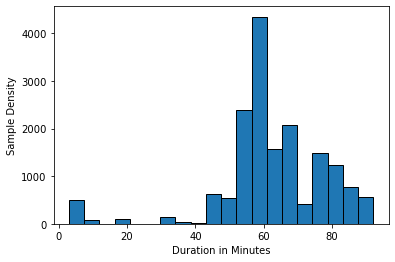

In [10]:
df.duration_minutes.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Duration in Minutes')
plt.ylabel('Sample Density')

Text(0, 0.5, 'Sample Density')

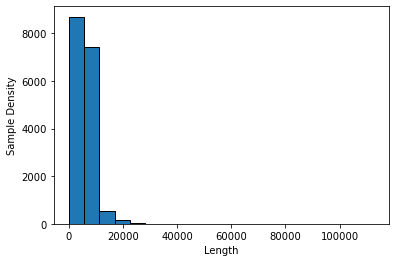

In [11]:
df_copy = df.to_crs('epsg:4509')
df_copy['length'] = df.length
df_copy.length.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Length')
plt.ylabel('Sample Density')

Text(0, 0.5, 'Sample Density')

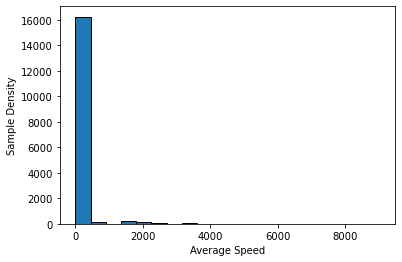

In [12]:
df_copy['average_speed'] = df_copy.length / df_copy.duration_minutes
df_copy.average_speed.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Average Speed')
plt.ylabel('Sample Density')

In [13]:
# clean 
df_clean = df
df_clean_copy = df_clean.to_crs('epsg:4509')

def pair(list):
    for i in range(1, len(list)):
        yield list[i-1],list[i]
        
max_list = []
df_count = 0
for i in df_clean_copy.geometry:
    test_list = list(i.coords)
    a_float = []
    k = 0
    for pt1,pt2 in pair(test_list):
        a_float.append(LineString([pt1,pt2]).length)
        k = k + 1
    df_clean_copy.loc[df_count,'max_length'] = max(a_float)
    df_clean_copy.loc[df_count,'count_time'] = k
    max_list.append(max(a_float))
    df_count = df_count + 1
df_clean_copy['max_speed'] = df_clean_copy['max_length'] * df_clean_copy['count_time'] / df_clean_copy['duration_minutes']


In [14]:
df_clean_copy.max_speed.describe()

count     16856.000000
mean        591.924164
std        3026.427739
min           0.000000
25%         162.671018
50%         204.461093
75%         290.329521
max      148294.245485
Name: max_speed, dtype: float64

In [15]:
df_clean_copy_clear = df_clean_copy.drop(df_clean_copy[df_clean_copy['max_speed']>745].index)
df_clean_clear = df_clean_copy_clear.to_crs('epsg:4509')

In [16]:
df_clean_copy_clear.max_speed.describe()

count    15516.000000
mean       227.800225
std        107.937346
min          0.000000
25%        159.240356
50%        197.511845
75%        257.523277
max        744.042870
Name: max_speed, dtype: float64

<AxesSubplot:>

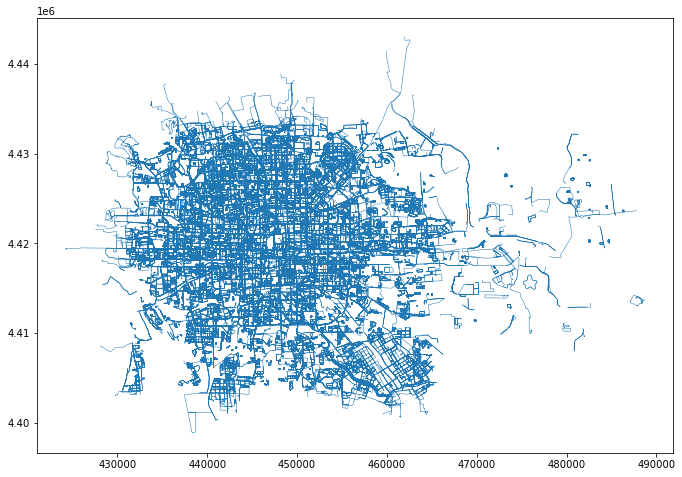

In [17]:
df_clean_clear.plot(figsize = (12,8),linewidth = 0.5)

Text(0, 0.5, 'Sample Density')

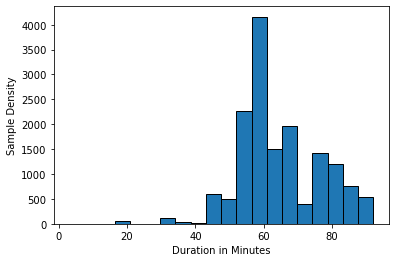

In [18]:
df_clean_clear.duration_minutes.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Duration in Minutes')
plt.ylabel('Sample Density')

Text(0, 0.5, 'Sample Density')

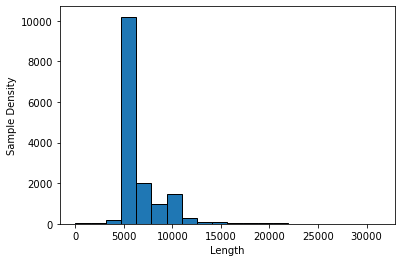

In [19]:
df_clean_copy_clear.length.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Length')
plt.ylabel('Sample Density')

Text(0, 0.5, 'Sample Density')

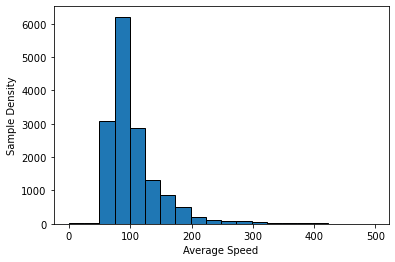

In [20]:
df_clean_copy_clear['average_speed'] = df_clean_copy_clear.length / df_clean_copy_clear.duration_minutes
df_clean_copy_clear.average_speed.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Average Speed')
plt.ylabel('Sample Density')

In [21]:
df_clean_clear.to_file('../04_output/df_copy_clear_copy.shp')

Text(0, 0.5, 'Sample Density')

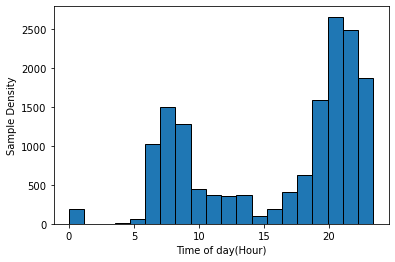

In [22]:
# describe the spatial attribute of the data in one timeset:
# reference to "Characterizing the activity patterns of outdoor jogging using massive multi-aspect trajectory data": 
# https://www.sciencedirect.com/science/article/pii/S0198971522000485

# the relationship between 'time of day(Hour)' and 'density' 
# 临时使用的方法，不可取！之后必须用正常的时间提取改过来
df_clean_clear['starttime_hour'] = (df_clean_clear.start-df_clean_clear.start.min())/60/60
df_clean_clear.starttime_hour.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Time of day(Hour)')
plt.ylabel('Sample Density')

In [23]:
df_clean_clear.head()

,start_datetime,end_datetime,start,end,geometry,duration,start_latitude,start_longitude,end_latitude,end_longitude,duration_minutes,max_length,count_time,max_speed,starttime_hour
0,2022-03-25 22:18:06,2022-03-25 23:18:04,2240286,2243884,"LINESTRING (452964.718 4428716.484, 452959.397...",0 days 00:59:58,39.991374,116.449267,39.991084,116.449337,59.0,71.034617,157.0,189.024321,22.300833
1,2022-03-25 22:51:04,2022-03-25 23:45:04,2242264,2245504,"LINESTRING (453666.635 4418009.732, 453647.779...",0 days 00:54:00,39.894989,116.458246,39.894943,116.460052,54.0,46.394287,281.0,241.422121,22.850278
2,2022-03-25 11:12:03,2022-03-25 12:18:03,2200323,2204283,"LINESTRING (441853.372 4420232.865, 441867.062...",0 days 01:06:00,39.914282,116.319930,39.916928,116.306100,66.0,72.958934,169.0,186.819088,11.200000
3,2022-03-25 19:18:05,2022-03-25 20:15:03,2229485,2232903,"LINESTRING (442554.868 4428634.785, 442572.853...",0 days 00:56:58,39.989995,116.327393,39.989385,116.327393,56.0,72.802508,186.0,241.808329,19.300556
4,2022-03-25 13:00:03,2022-03-25 14:15:02,2206803,2211302,"LINESTRING (438026.918 4414423.880, 438072.230...",0 days 01:14:59,39.861697,116.275730,39.861787,116.275610,74.0,71.726453,221.0,214.210082,13.000000


Text(0, 0.5, 'Sample Density')

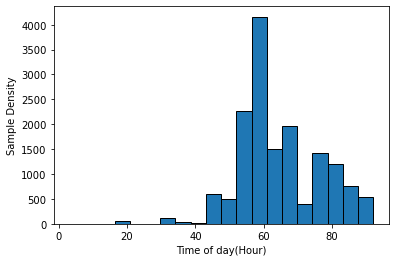

In [24]:
df_clean_clear.duration_minutes.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('Time of day(Hour)')
plt.ylabel('Sample Density')

In [25]:
# 接下来整合清华范围的格网和keep数据进行分析

thu = gpd.read_file('../../202203_Campus/03_data/GIS/tsinghua.shp')
thu.crs = 'epsg:4326'
df_clean_clear = df_clean_clear.to_crs('epsg:4326')
sjoin_intersects = gpd.sjoin(df_clean_clear, thu, op='intersects')

<AxesSubplot:>

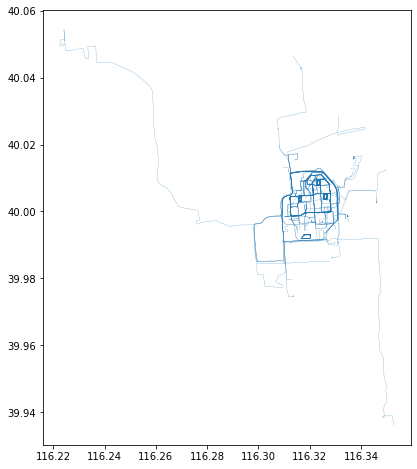

In [26]:
# 与清华相关的路径提取
sjoin_intersects.plot(figsize = (12,8),linewidth = 0.2)

<AxesSubplot:>

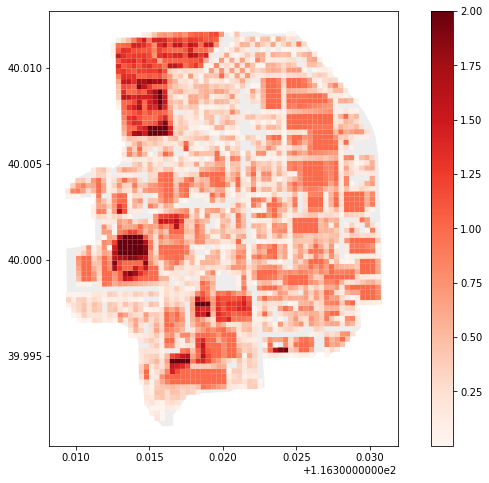

In [27]:
# 清华校内的格网导入与相关属性可视化

grid_copy_test = gpd.read_file('../../202203_Campus/03_data/GIS/campus_landuse_grid.shp')
import matplotlib.pyplot as plt
ax = thu.plot(figsize=(12,8),facecolor='lightgrey', edgecolor='white', alpha=0.4)
grid_copy_test.plot(ax=ax, column = 'OSM_area', cmap=Reds_9.mpl_colormap, legend=True)

In [28]:
sjoin_intersects.crs = 'epsg:4326'
thu_keep_4509 = sjoin_intersects.to_crs('epsg:4509')

In [29]:
thu_keep_4509.geometry.length.describe()

count      146.000000
mean      6864.076328
std       2563.723970
min       4315.671804
25%       5102.743910
50%       5736.398460
75%       8011.952393
max      21310.763879
dtype: float64

In [30]:
# calculate the intersection length of the keep LineString with the grid:
# 本次统计方式是将一天的数据加到一个grid上，抹去时间分布只看空间分布。

sjoin_intersects['length'] = thu_keep_4509.geometry.length
grid_keep = grid_copy_test

for i in grid_keep.index:
    grid_keep.loc[i,'keep_length'] = 0
    grid_keep.loc[i,'length_average'] = 0
    grid_keep.loc[i,'keep_num'] = 0
    clip = gpd.overlay(sjoin_intersects, grid_keep[i:i+1], how='intersection')
    if len(clip)>=1:
        for j in clip.index:
            grid_keep.loc[i,'length_average'] = grid_keep.loc[i,'length_average'] + clip.loc[j,'length']
            grid_keep.loc[i,'keep_length'] = grid_keep.loc[i,'keep_length'] + clip.loc[j,'geometry'].length
            grid_keep.loc[i,'keep_num'] = grid_keep.loc[i,'keep_num'] + 1
    else:
        pass
    
grid_notna = grid_keep.drop(grid_keep[grid_keep['keep_num'] == 0].index)
grid_notna = grid_notna[grid_notna.OSM_area.notna()]
grid_notna.length_average = grid_notna.length_average / grid_notna.keep_num
grid_notna.length_average.describe()

count     1390.000000
mean      8069.291316
std       2159.797371
min       4779.810238
25%       6541.514782
50%       7647.548196
75%       9405.771385
max      15956.157977
Name: length_average, dtype: float64

In [40]:
len(grid_notna)

1390

### 创建速度属性

In [51]:
# 根据GPS定位次数创建路段文件，计算并赋予速度属性
a_gdf_4326 = gpd.GeoDataFrame(data = None, columns = ['derive','length','duration','speed','geometry'])
a_gdf_4326.crs = 'epsg:4326'
for i in thu_keep_4509.index:
    a_gdf = gpd.GeoDataFrame(data = None, columns = ['derive','length','duration','speed','geometry'])
    a_gdf.crs = 'epsg:4509'
    test_list = list(thu_keep_4509.loc[i,'geometry'].coords)
    k = 0
    for pt1,pt2 in pair(test_list):
        a_gdf.loc[k,'derive'] = k+1
        a_gdf.loc[k,'length'] = LineString([pt1,pt2]).length
        a_gdf.loc[k,'duration'] = (thu_keep_4509.loc[i,'end'] - thu_keep_4509.loc[i,'start']) / len(test_list)
        a_gdf.loc[k,'speed'] = a_gdf.loc[k,'length'] / a_gdf.loc[k,'duration']
        a_gdf.loc[k,'geometry'] = LineString([pt1,pt2])
        k = k + 1
    a_gdf_4326 = a_gdf_4326.append(a_gdf.to_crs('epsg:4326'))

<AxesSubplot:>

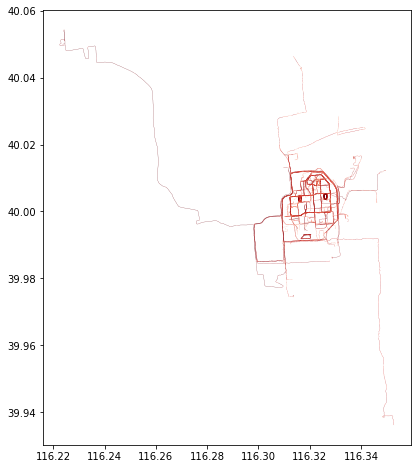

In [32]:
# 每个路段速度的简单可视化
a_gdf_4326.plot(figsize = (12,8),column = 'speed', cmap=Reds_9.mpl_colormap,linewidth = 0.2)

In [42]:
# 将路段文件与网格做交集 注意！这个要算约1300*2136次，我的Mac要做三个小时！

for x in grid_keep.index:
    if grid_keep.loc[x,'keep_num'] == 0:#针对每个网格赋值 筛去没有重合的网格，有效减少总运算量
        pass
    else:
        clip = gpd.overlay(a_gdf_4326, grid_keep[x:x+1], how='intersection')
        grid_keep.loc[x,'speed'] = 0
        speed_variable = 0
        if len(clip)>=1:
            for j in clip.index:
                speed_variable = speed_variable + clip.loc[j,'speed_1'] * clip.loc[j,'geometry'].length
            grid_keep.loc[x,'speed'] = speed_variable / grid_keep.loc[x,'keep_length']
        else:
            pass

In [43]:
grid_keep.speed.describe()

count    2136.000000
mean        2.636329
std         1.111159
min         0.000000
25%         1.931962
50%         2.510631
75%         3.127889
max        11.214713
Name: speed, dtype: float64

In [47]:
grid_keep.head(1)

,built_area,num_bldg,building_a,OSM_area,other_tags,landuse_ar,leisure_ar,natural_ar,tourism_ar,amenity_ar,...,place_area,shop_area,office_are,barrier_ar,man_made_a,geometry,keep_length,length_average,keep_num,speed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.30939 39.99130, 116.30939 39.991...",0.0,0.0,0.0,0.0


<AxesSubplot:>

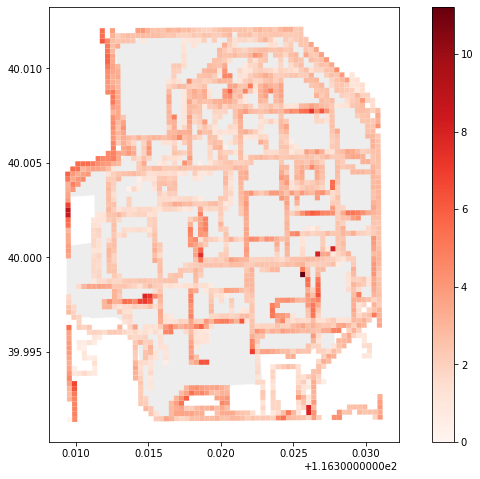

In [45]:
# 速度信息简单可视化

ax = thu.plot(figsize=(12,8),facecolor='lightgrey', edgecolor='white', alpha=0.4)
grid_keep.plot(ax=ax, column = 'speed', cmap=Reds_9.mpl_colormap, legend=True)

In [48]:
grid_keep.to_file('../../202203_Campus/03_data/05_22/0425_tsinghua_train.shp')

<AxesSubplot:>

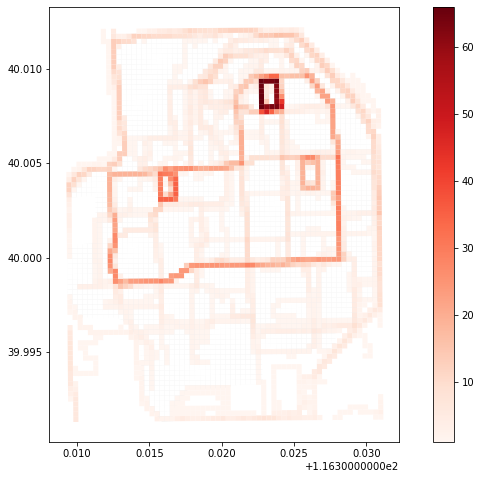

In [49]:
# 对跑步经过次数的简单量化

grid_keep_notna = grid_keep.drop(grid_keep[grid_keep['keep_num'] == 0].index)
grid_keep_na = grid_keep.drop(grid_keep[grid_keep['keep_num'] != 0].index)
ax = thu.plot(figsize=(12,8),facecolor='lightgrey', edgecolor='white', alpha=0.4)
grid_keep_na.plot(ax=ax, facecolor = 'white', legend=True)
grid_keep_notna.plot(ax=ax, column = 'keep_num', cmap=Reds_9.mpl_colormap, legend=True)

In [52]:
# OSM和keep目前在格网上的交集,即有效样本量

grid_notna = grid_keep.drop(grid_keep[grid_keep['keep_num'] == 0].index)
grid_notna = grid_notna[grid_notna.OSM_area.notna()]
grid_notna.keep_num.describe()

count    1390.000000
mean        6.813669
std         9.829018
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max        66.000000
Name: keep_num, dtype: float64

<AxesSubplot:>

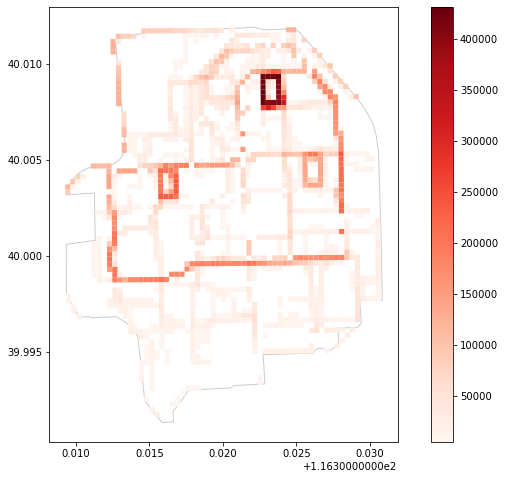

In [53]:
#### length_average识别
ax = thu.plot(figsize=(12,8),facecolor='white', edgecolor='gray', alpha=0.4)
grid_notna.plot(ax=ax, column = 'length_average', cmap=Reds_9.mpl_colormap, legend=True)

<AxesSubplot:>

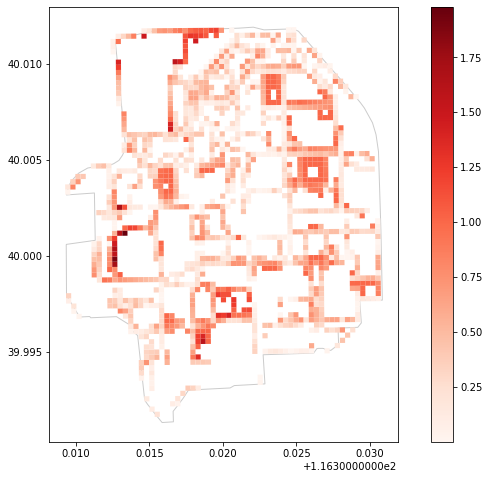

In [54]:
#### OSM_area
x = thu.plot(figsize=(12,8),facecolor='white', edgecolor='gray', alpha=0.4)
grid_notna.plot(ax=ax, column = 'OSM_area', cmap=Reds_9.mpl_colormap, legend=True)

<AxesSubplot:>

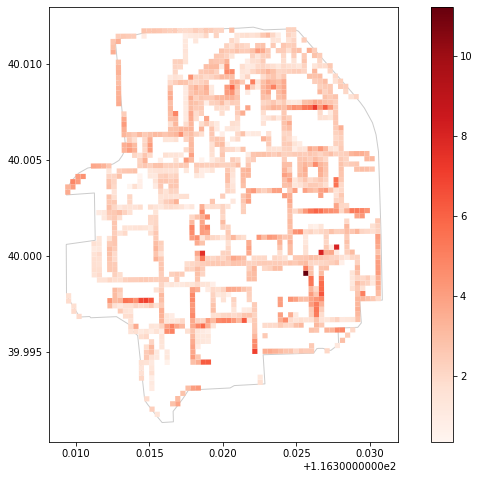

In [56]:
#### speed
ax = thu.plot(figsize=(12,8),facecolor='white', edgecolor='gray', alpha=0.4)
grid_notna.plot(ax=ax, column = 'speed', cmap=Reds_9.mpl_colormap, legend=True)

In [57]:
grid_notna.head(1)

,built_area,num_bldg,building_a,OSM_area,other_tags,landuse_ar,leisure_ar,natural_ar,tourism_ar,amenity_ar,...,place_area,shop_area,office_are,barrier_ar,man_made_a,geometry,keep_length,length_average,keep_num,speed
23,NaN,1.0,0.080656,0.080656,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.30933 39.99751, 116.30932 39.997...",0.000338,15301.287066,2.0,1.86238


## 领域权重

<AxesSubplot:>

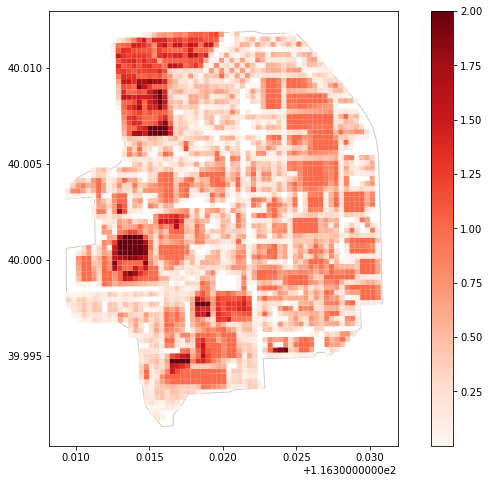

In [331]:

ax = thu.plot(figsize=(12,8),facecolor='white', edgecolor='gray', alpha=0.4)
grid_keep.plot(ax=ax, column = 'OSM_area', cmap=Reds_9.mpl_colormap, legend=True)

### 对该表的初步线性分析
    # 线性回归 statsmodels
    # 非线性的分类和回归 sklearn  scipy  

    # 降维
    # 随机森林 支持向量机 adaboost

### 想一想时间属性可以怎么用？ # 速度文件是可行的，在另一文件中得以解决。但伴随时间变化的关系呢？

In [58]:
import sklearn
import scipy
import statsmodels

In [59]:
grid_notna.select_dtypes(include = ['float']).describe()

,built_area,num_bldg,building_a,OSM_area,other_tags,landuse_ar,leisure_ar,natural_ar,tourism_ar,amenity_ar,sport_area,place_area,shop_area,office_are,barrier_ar,man_made_a,keep_length,length_average,keep_num,speed
count,3.500000e+01,1390.000000,849.000000,1390.000000,735.000000,323.000000,371.000000,94.000000,16.000000,179.000000,212.000000,2.000000,7.000000,18.000000,6.000000,4.000000,1.390000e+03,1390.000000,1390.000000,1390.000000
mean,6.634246e-08,1.408633,0.246207,0.447505,0.392697,0.480288,0.495652,0.349992,0.096893,0.265966,0.528347,0.257818,0.237189,0.127975,0.490529,0.210420,5.785864e-03,52054.631228,6.813669,2.554881
std,3.476990e-08,0.663724,0.229093,0.338994,0.323825,0.335035,0.353520,0.274535,0.087832,0.234193,0.356987,0.330289,0.186306,0.131661,0.112056,0.215432,2.374626e-02,68496.627123,9.829018,1.069802
min,9.032962e-09,1.000000,0.000007,0.000007,0.000003,0.000002,0.000807,0.005793,0.000007,0.000005,0.000171,0.024268,0.012987,0.000093,0.282689,0.006507,4.736281e-08,4779.810238,1.000000,0.347975
25%,3.910699e-08,1.000000,0.056993,0.166419,0.104772,0.176073,0.143183,0.110431,0.031055,0.059960,0.163141,0.141043,0.090176,0.033279,0.475323,0.079429,3.517878e-04,10516.335084,1.000000,1.843622
50%,7.423914e-08,1.000000,0.177166,0.381156,0.311887,0.470971,0.500265,0.267154,0.086552,0.200146,0.515231,0.257818,0.220842,0.110108,0.517253,0.165775,7.457651e-04,23744.464002,3.000000,2.452733
75%,9.491657e-08,2.000000,0.379085,0.674362,0.639460,0.766864,0.826880,0.564536,0.138726,0.409615,0.892587,0.374593,0.385228,0.168352,0.553122,0.296766,2.224327e-03,64602.387973,8.000000,3.017290
max,1.386279e-07,5.000000,1.000000,1.979110,1.000000,1.000000,1.000000,1.000000,0.308728,0.997844,1.000000,0.491368,0.475684,0.485206,0.599553,0.503623,2.780283e-01,431684.276618,66.000000,11.214713


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<AxesSubplot:>

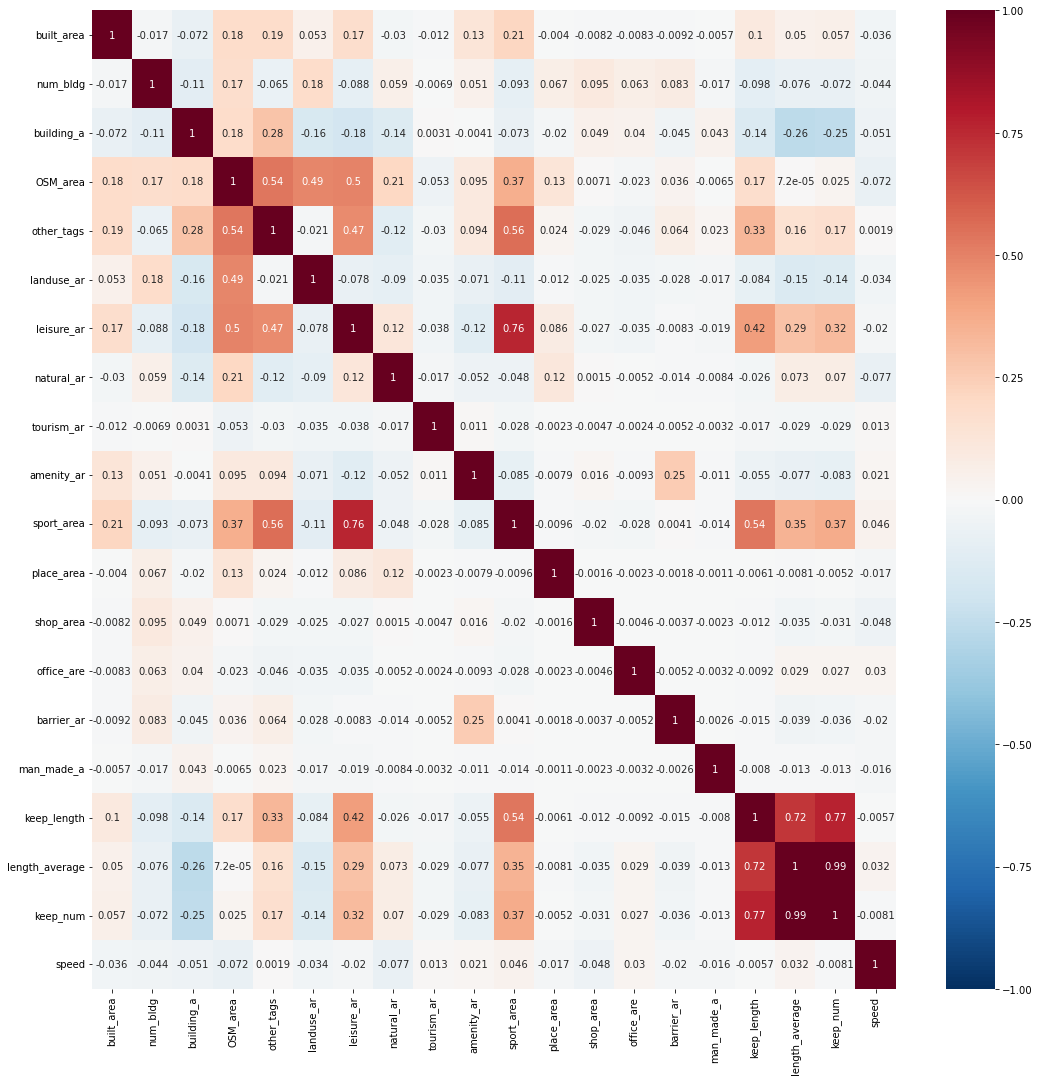

In [71]:
plt.figure(figsize = (18,18))
sns.heatmap(grid_notna.fillna(0).corr(), annot=True,vmin=-1, vmax=1, cmap = 'RdBu_r')

In [335]:
grid_keep

,built_area,num_bldg,building_a,OSM_area,other_tags,landuse_ar,leisure_ar,natural_ar,tourism_ar,amenity_ar,...,place_area,shop_area,office_are,barrier_ar,man_made_a,geometry,keep_length,length_average,keep_num,speed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.30939 39.99130, 116.30939 39.991...",0.000000,0.000000,0.0,0.00000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.30939 39.99157, 116.30938 39.991...",0.000000,0.000000,0.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.30938 39.99184, 116.30938 39.992...",0.000000,0.000000,0.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.30938 39.99211, 116.30938 39.992...",0.000000,0.000000,0.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.30938 39.99238, 116.30938 39.992...",0.000114,7122.900463,1.0,2.97349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.33063 40.01087, 116.33062 40.011...",0.000000,0.000000,0.0,NaN
4770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.33062 40.01114, 116.33062 40.011...",0.000000,0.000000,0.0,NaN
4771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.33062 40.01141, 116.33062 40.011...",0.000000,0.000000,0.0,NaN
4772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((116.33062 40.01168, 116.33061 40.011...",0.000000,0.000000,0.0,NaN


## 模型测试
### 已有变量整理：

有一个问题…如果以格网为对象进行调查，变量数目就会被限制了



In [135]:
trainsample_0425 = grid_notna.fillna(0)

Text(0, 0.5, 'Sample Density')

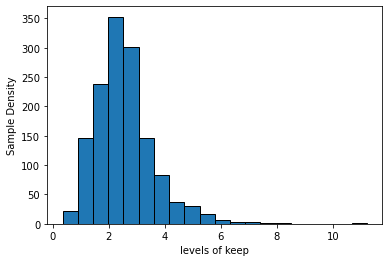

In [329]:
trainsample_0425.speed.hist(bins=20, edgecolor='black', grid=False)
plt.xlabel('levels of keep')
plt.ylabel('Sample Density')

#### 描述正态分布与等级划分 离散化

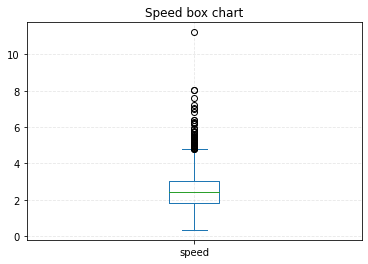

In [179]:
trainsample_0425.speed.plot.box(title="Speed box chart")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

In [252]:
# 速度字段分类
df = pd.DataFrame(trainsample_0425.speed)
describe_df = df.describe()
for i in df.index:
    if df.loc[i,'speed'] <= describe_df.loc['25%','speed']:
        df.loc[i,'type'] = 0
    if ( df.loc[i,'speed'] <= describe_df.loc['50%','speed'] ) and ( df.loc[i,'speed'] > describe_df.loc['25%','speed']):
        df.loc[i,'type'] = 1
    if ( df.loc[i,'speed'] <= describe_df.loc['75%','speed'] ) and ( df.loc[i,'speed'] > describe_df.loc['50%','speed']):
        df.loc[i,'type'] = 2
    if ( df.loc[i,'speed'] <= describe_df.loc['max','speed'] ) and ( df.loc[i,'speed'] > describe_df.loc['75%','speed']):
        df.loc[i,'type'] = 3
speed_type_y = df.type.to_numpy()

### 特征工程

#### 数值字段标准化

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
campus_columns = ['built_area','num_bldg','building_a','OSM_area','other_tags','landuse_ar','leisure_ar','natural_ar','tourism_ar','amenity_ar','sport_area','place_area','shop_area','office_are','barrier_ar','man_made_a']


In [5]:
standardScaler = StandardScaler

In [6]:
num_feature = standardScaler.fit_transform(trainsample_0425[campus_columns])

NameError: name 'trainsample_0425' is not defined

In [142]:
num_feature

array([[-0.14240558, -0.61588834, -0.32358915, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834,  0.86784611, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834, -0.55716728, ..., -0.08073542,
        -0.06445027, -0.04017112],
       ...,
       [-0.14240558, -0.61588834, -0.69790722, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834, -0.28589752, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834, -0.68993952, ..., -0.08073542,
        -0.06445027, -0.04017112]])

In [143]:
keep_columns = ['keep_length','length_average','keep_num','speed']

In [144]:
keep_feature = standardScaler.fit_transform(trainsample_0425[keep_columns])

In [145]:
keep_feature

array([[-0.2294961 , -0.53676471, -0.48991683, -0.64755   ],
       [-0.24022516, -0.65390717, -0.591693  , -0.82999455],
       [-0.15432674,  0.485029  ,  0.12074023,  0.98043786],
       ...,
       [-0.23234485, -0.6036126 , -0.591693  , -0.40775407],
       [-0.22153427, -0.50840032, -0.48991683, -0.33342978],
       [-0.2095208 , -0.34919994, -0.38814065, -0.09554028]])

### 构建X和y

In [186]:
campus_X = np.hstack([num_feature])
campus_X

array([[-0.14240558, -0.61588834, -0.32358915, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834,  0.86784611, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834, -0.55716728, ..., -0.08073542,
        -0.06445027, -0.04017112],
       ...,
       [-0.14240558, -0.61588834, -0.69790722, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834, -0.28589752, ..., -0.08073542,
        -0.06445027, -0.04017112],
       [-0.14240558, -0.61588834, -0.68993952, ..., -0.08073542,
        -0.06445027, -0.04017112]])

In [207]:
speed_y = trainsample_0425['speed'].to_numpy()
speed_y

array([1.86237997, 1.66727065, 3.60337813, ..., 2.11882186, 2.19830554,
       2.45270865])

In [208]:
speed_y_copy = campus_y / np.max(speed_y)
speed_y_copy

array([0.16606577, 0.14866815, 0.32130809, ..., 0.18893232, 0.19601977,
       0.21870453])

In [209]:
num_y = trainsample_0425['keep_num'].to_numpy()
num_y

array([2., 1., 8., ..., 1., 2., 3.])

In [211]:
num_y_copy = num_y / np.max(num_y)
num_y_copy

array([0.03030303, 0.01515152, 0.12121212, ..., 0.01515152, 0.03030303,
       0.04545455])

## 特征选择（降维）

### 线性降维方法 
假设数据采集来自高维空间的一个全局线性子空间，即构成数据的各变量之间是独立无关的。
#### PCA 主成分分析
对原始的空间中顺序地找一组相互正交的坐标轴，第一个轴是使得方差最大的，第二个周是在在与第一个轴正交的平面中使得方差最大的，第三个轴是在与第1，2个轴正交的平面中方差最大的。这样假设，在N维空间中我们能找到N个这样的坐标轴，我们取前r个去近似这个空间吗，这样就可以使得N维降到r维了，但我们选择的r个坐标轴能使得空间的压缩使得数据的损失最小。

In [146]:
##用于3D可视化
from mpl_toolkits.mplot3d import Axes3D
##用于可视化图表
import matplotlib.pyplot as plt
##用于做科学计算
import numpy as np
##用于做数据分析
import pandas as pd
##用于加载数据或生成数据等
from sklearn import datasets
##导入PCA库
from sklearn.decomposition import PCA
##导入LDA库
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [287]:
campus_y = speed_y

In [197]:
print('campus_X.shape' + str(campus_X.shape))
print('campus_y.shape' + str(campus_y.shape))

campus_X.shape(1390, 16)
campus_y.shape(1390,)


In [198]:
## 加载PCA的模型并训练、降维
model_pca = PCA(n_components=3)
X_pca = model_pca.fit(campus_X).transform(campus_X)
print(campus_X.shape)
print(campus_X[0:5])
print(X_pca.shape)
print(X_pca[0:5])

(1390, 16)
[[-0.14240558 -0.61588834 -0.32358915 -1.08255918 -0.67800347 -0.43069114
  -0.46386552 -0.20947795 -0.0808984  -0.28002799 -0.34227806 -0.02812366
  -0.05748805 -0.08073542 -0.06445027 -0.04017112]
 [-0.14240558 -0.61588834  0.86784611 -0.32497569 -0.67800347 -0.43069114
  -0.46386552 -0.20947795 -0.0808984  -0.28002799 -0.34227806 -0.02812366
  -0.05748805 -0.08073542 -0.06445027 -0.04017112]
 [-0.14240558 -0.61588834 -0.55716728 -1.23108167 -0.57898509 -0.43069114
  -0.46386552 -0.20947795 -0.0808984  -0.28002799 -0.34227806 -0.02812366
  -0.05748805 -0.08073542 -0.06445027 -0.04017112]
 [-0.14240558 -0.61588834  0.07209102 -0.83096283 -0.13626684 -0.43069114
  -0.46386552 -0.20947795 -0.0808984  -0.28002799 -0.34227806 -0.02812366
  -0.05748805 -0.08073542 -0.06445027 -0.04017112]
 [-0.14240558 -0.61588834 -0.59567716 -1.25556848 -0.67800347 -0.43069114
  -0.46386552 -0.20947795 -0.0808984  -0.28002799 -0.34227806 -0.02812366
  -0.05748805 -0.08073542 -0.06445027 -0.0401

In [199]:
# 13维的数据降到了3维，接下来看前后的方差分布
model_pca = PCA(n_components=16)
X_pca = model_pca.fit(campus_X).transform(campus_X)
print("各主成分方向：\n",model_pca.components_)
print("各主成分的方差值：",model_pca.explained_variance_)
print("各主成分的方差值与总方差之比：",model_pca.explained_variance_ratio_)
print("奇异值分解后得到的特征值：",model_pca.singular_values_)
print("主成分数：",model_pca.n_components_)

各主成分方向：
 [[ 2.14787934e-01 -1.75184363e-02  3.01425973e-02  4.58144927e-01
   4.73423610e-01  7.24821605e-02  5.05678722e-01  3.93037719e-02
  -4.46542105e-02  7.40286973e-03  4.97444190e-01  6.32209458e-02
  -2.15857821e-02 -3.98850639e-02  2.30240988e-02 -5.59268758e-03]
 [ 4.16015397e-02  5.15493330e-01 -2.06902992e-01  3.88576839e-01
  -1.33488090e-01  5.85763276e-01 -1.17306524e-01  1.99102790e-01
  -6.18000241e-02  1.25741320e-01 -2.30486435e-01  1.64680693e-01
   7.22448225e-02  1.41173554e-02  1.25662572e-01 -5.75426588e-02]
 [ 8.56491837e-02  3.77694969e-02  5.03293498e-01  1.16331636e-01
   2.93355546e-01  1.83580408e-02 -2.80751939e-01 -3.95630051e-01
   2.24966683e-02  4.89919087e-01 -1.32624923e-01 -1.48942181e-01
   8.86130178e-02  3.41092919e-02  3.28405352e-01  7.41300507e-02]
 [ 2.03392533e-01  4.84413304e-02 -4.61477620e-01 -2.03377713e-01
  -1.01488329e-01 -3.34087774e-01  1.24373819e-01  1.73827783e-01
   5.45369206e-02  4.82219708e-01  9.55537789e-02  4.93578100e-0

In [200]:
model_pca = PCA(n_components=3)
X_pca = model_pca.fit(campus_X).transform(campus_X)
print("各主成分方向：\n",model_pca.components_)
print("各主成分的方差值：",model_pca.explained_variance_)
print("各主成分的方差值与总方差之比：",model_pca.explained_variance_ratio_)
print("奇异值分解后得到的特征值：",model_pca.singular_values_)
print("主成分数：",model_pca.n_components_)

各主成分方向：
 [[ 0.21478849 -0.01751831  0.0301356   0.45814241  0.47343835  0.07248089
   0.5056742   0.03930624 -0.04465447  0.00739918  0.4974374   0.0632204
  -0.02158564 -0.03988454  0.02302403 -0.00559304]
 [ 0.04161724  0.51549742 -0.20704421  0.38850005 -0.13317452  0.58575797
  -0.11746075  0.19918366 -0.06181182  0.12566541 -0.2305601   0.16467504
   0.07224027  0.01412634  0.12567097 -0.05755067]
 [ 0.08565449  0.03777723  0.50324853  0.11640354  0.29339576  0.01827149
  -0.28057188 -0.39570127  0.02250637  0.48990264 -0.13288723 -0.14897346
   0.0886118   0.03411286  0.32838627  0.07413365]]
各主成分的方差值： [2.71991806 1.5561122  1.40308431]
各主成分的方差值与总方差之比： [0.16987258 0.09718704 0.08762968]
奇异值分解后得到的特征值： [61.46516239 46.49128791 44.14616749]
主成分数： 3


### PCA 可视化

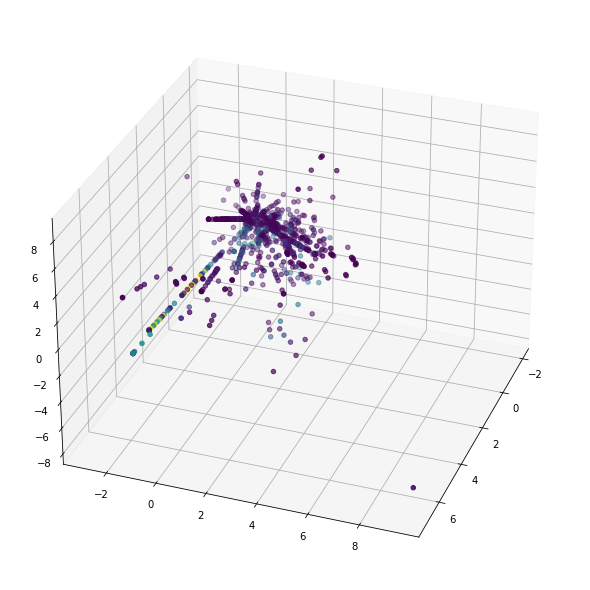

In [286]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig,rect=[0, 0, 1, 1], elev=30, azim=20)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], marker='o',c=num_y_copy)

In [269]:
campus_y

array([1., 0., 3., ..., 1., 1., 1.])

feature importance score

### 模型训练（针对OSM和speed）

#### 数集划分

In [290]:
from sklearn.model_selection import train_test_split

In [291]:
X_train, X_test, y_train, y_test = train_test_split(campus_X, campus_y, test_size=0.2)

In [292]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1112, 16), (278, 16), (1112,), (278,))

In [293]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(campus_X, speed_type_y, test_size=0.2)

In [294]:
X_train_2.shape, X_test_2.shape, y_train_2.shape, y_test_2.shape

((1112, 16), (278, 16), (1112,), (278,))

#### 随机森林

In [295]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#### classifier

In [296]:
classifier_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [297]:
classifier_model.fit(X_train_2, y_train_2)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [298]:
y_pred = classifier_model.predict(X_test_2)
y_pred

array([0., 0., 2., 2., 3., 0., 0., 0., 3., 0., 0., 1., 1., 1., 2., 2., 2.,
       3., 3., 1., 0., 0., 0., 2., 3., 2., 1., 3., 1., 2., 0., 2., 2., 3.,
       2., 2., 2., 0., 2., 0., 2., 1., 1., 3., 0., 0., 3., 1., 0., 0., 0.,
       1., 3., 2., 2., 2., 1., 2., 3., 2., 0., 2., 1., 3., 3., 3., 3., 0.,
       0., 3., 3., 2., 1., 0., 2., 2., 0., 3., 3., 0., 2., 3., 2., 0., 2.,
       2., 2., 1., 2., 1., 1., 0., 1., 2., 0., 1., 3., 1., 2., 0., 1., 0.,
       2., 0., 0., 2., 2., 0., 3., 2., 3., 2., 3., 1., 2., 0., 1., 1., 0.,
       2., 1., 3., 0., 2., 0., 0., 1., 2., 1., 0., 1., 1., 3., 0., 1., 3.,
       1., 0., 2., 2., 1., 1., 2., 1., 3., 1., 2., 1., 3., 2., 1., 2., 2.,
       2., 2., 2., 3., 0., 0., 2., 3., 0., 0., 3., 2., 2., 0., 2., 0., 2.,
       0., 0., 3., 1., 2., 0., 0., 0., 3., 0., 3., 3., 2., 3., 3., 2., 3.,
       0., 0., 2., 0., 3., 0., 1., 1., 2., 2., 0., 0., 2., 0., 2., 2., 3.,
       2., 1., 0., 2., 1., 0., 2., 3., 0., 1., 0., 1., 0., 2., 3., 3., 1.,
       1., 1., 3., 3., 1.

In [299]:
classifier_model.score(X_train_2, y_train_2)

0.9820143884892086

In [300]:
classifier_model.score(X_test_2, y_test_2)

0.34172661870503596

####  regressor

In [304]:
random_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

In [305]:
random_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [306]:
y_pred = random_model.predict(X_test)
y_pred

array([3.1320124 , 2.55492437, 2.14822144, 2.20513336, 1.71405143,
       2.65004646, 3.70440806, 1.91304872, 2.04962071, 2.86286783,
       3.00485534, 2.78597674, 1.88517969, 1.28239098, 2.2636551 ,
       1.59314696, 2.69032393, 2.42492155, 1.61162314, 2.76266347,
       2.19548172, 3.24672361, 3.05259531, 2.03711317, 4.02964711,
       2.33310217, 2.0348972 , 2.52802289, 3.09305928, 1.77473794,
       2.38194113, 1.99986457, 3.22468958, 2.2304424 , 3.63509806,
       2.54659083, 2.5443339 , 3.30123985, 2.4423112 , 3.36397346,
       2.25871776, 2.10862206, 2.65831263, 2.36584672, 2.17652451,
       2.64931533, 1.98552089, 2.39795841, 2.31552537, 2.70096546,
       2.29130718, 2.35499518, 1.47071774, 2.13462622, 3.08117241,
       1.99932695, 2.88778021, 3.2439085 , 2.61400551, 1.95590485,
       1.47162247, 2.5995741 , 2.78631422, 2.38367863, 2.80230157,
       2.88778021, 2.67949366, 2.21746355, 3.14500524, 2.5950563 ,
       1.31388415, 2.37819612, 3.27429122, 2.96642802, 2.18201

In [307]:
random_model.score(X_train, y_train)

0.7678984671921596

In [308]:
random_model.score(X_test, y_test)

-0.11204101879937944

### 模型训练（OSM-keep_num）

#### 数集划分

In [309]:
from sklearn.model_selection import train_test_split

In [310]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(campus_X, num_y, test_size=0.2)

In [311]:
X_train_3.shape, X_test_3.shape, y_train_3.shape, y_test_3.shape

((1112, 16), (278, 16), (1112,), (278,))

#### 随机森林

In [312]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#### classifier

In [313]:
classifier_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

In [314]:
classifier_model.fit(X_train_3, y_train_3)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [315]:
y_pred = classifier_model.predict(X_test_3)
y_pred

array([ 6., 19.,  9.,  1.,  1.,  1.,  1.,  3., 25.,  3.,  1.,  4.,  1.,
       10., 12.,  2.,  1.,  4., 24.,  2.,  1.,  9.,  1., 23., 15.,  1.,
        4.,  5., 19.,  1.,  5.,  1.,  4., 14.,  2.,  2.,  1.,  1.,  1.,
        4., 19.,  4.,  1.,  2.,  1.,  2.,  1.,  4.,  3.,  2.,  4.,  7.,
        1.,  1., 19.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  1.,  1., 17.,
        5.,  4.,  1.,  2., 14., 12.,  1.,  4.,  2.,  3., 24., 19.,  1.,
        2., 19., 12.,  2., 25.,  3.,  1.,  4.,  3.,  5.,  1.,  1.,  1.,
        2., 12.,  3.,  1., 19.,  2., 21.,  1.,  2.,  2.,  5.,  6., 11.,
        1.,  7.,  4.,  5., 19., 12.,  2.,  1.,  1.,  6.,  3.,  2.,  4.,
        1.,  3.,  2.,  3.,  1.,  1.,  4.,  7.,  8.,  3.,  1.,  7.,  1.,
        1.,  3.,  1.,  1.,  5.,  5.,  2.,  1., 23.,  1.,  1.,  1.,  3.,
        5.,  1.,  1.,  2.,  1., 35.,  1., 10.,  1., 12.,  1.,  2.,  5.,
       15., 13.,  1.,  2.,  1.,  4., 65.,  2.,  2., 32.,  4., 23.,  2.,
        1.,  1., 23.,  1.,  4.,  1.,  1.,  1.,  2.,  4.,  6.,  2

In [316]:
classifier_model.score(X_train_3, y_train_3)

0.9757194244604317

In [318]:
classifier_model.score(X_test_3, y_test_3)

0.2697841726618705

####  regressor

In [319]:
random_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

In [324]:
random_model.fit(X_train_3, y_train_3)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [325]:
y_pred = random_model.predict(X_test_3)
y_pred

array([ 5.98333333, 13.1       ,  6.7       ,  1.07333333,  4.40333333,
        6.45333333,  1.37666667,  2.7       , 13.37      ,  2.46666667,
        1.57754644,  4.34      ,  7.41      ,  7.26      ,  6.78333333,
        2.87333333,  1.37666667,  3.05666667, 14.41666667,  3.85333333,
        4.54333333,  7.03333333,  6.02      , 17.4825    ,  8.29      ,
       20.30333333,  6.58      ,  5.08333333, 14.11666667,  5.75333333,
        3.95      ,  5.74      ,  3.38      ,  9.23333333,  3.37666667,
        1.98666667,  3.97666667,  1.60916667,  7.98333333,  3.40666667,
       20.10098743,  4.84      ,  7.09333333,  6.38333333,  3.32654661,
        3.30333333,  1.8975    ,  5.39666667,  2.47333333,  1.69      ,
        3.6       ,  5.28      ,  1.61666667,  1.86666667, 20.10098743,
        3.66333333,  1.40666667,  5.91333333,  1.9916453 ,  3.05666667,
        4.75333333,  1.87666667,  1.80333333,  7.57333333, 26.73      ,
        4.17      ,  4.46333333,  1.25666667,  4.68      , 12.13

In [326]:
random_model.score(X_train_3, y_train_3)

0.7861187230781717

In [327]:
random_model.score(X_test_3, y_test_3)

0.024396982661140987